- Carlos Fernández de la Torre 10/11/2019

# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Instalación e importación de librerías

In [7]:
%pip install split-folders
%pip install opencv-python
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182

https://www.linkedin.com/pulse/optimizando-tu-flujo-de-trabajo-explora-c%C3%B3mo-cargar-y-naren-fragozo/?originalSubdomain=es
https://stackoverflow.com/questions/53074712/how-to-split-folder-of-images-into-test-training-validation-sets-with-stratified
https://stackoverflow.com/questions/48735600/file-download-from-google-drive-to-colaboratory

In [1]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob
import splitfolders
import subprocess
import shutil
import tensorflow as tf
import PIL

## *(**Hacer solo una vez, en Colab**) Obtención del dataset en Google Drive*

Importamos la librería y montamos nuestra cuenta de Drive (nos pedirá permiso).

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

Creamos la carpeta de drive donde van a ir los datos

In [ ]:
!mkdir '/content/drive/My Drive/Colab Notebooks/db/'

Ahora debemos ir a nuestra cuenta de Kaggle y obtener un token con nuestras credenciales. Para ello:
1. Iniciamos sesión o nos registramos en Kaggle.
2. Vamos al icono de la esquina superior derecha y nos aparecerá un menú.

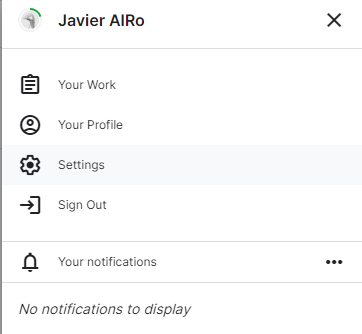
3. Le damos a "Settings"
4. Bajamos hasta API y le damos a "Create New Token"

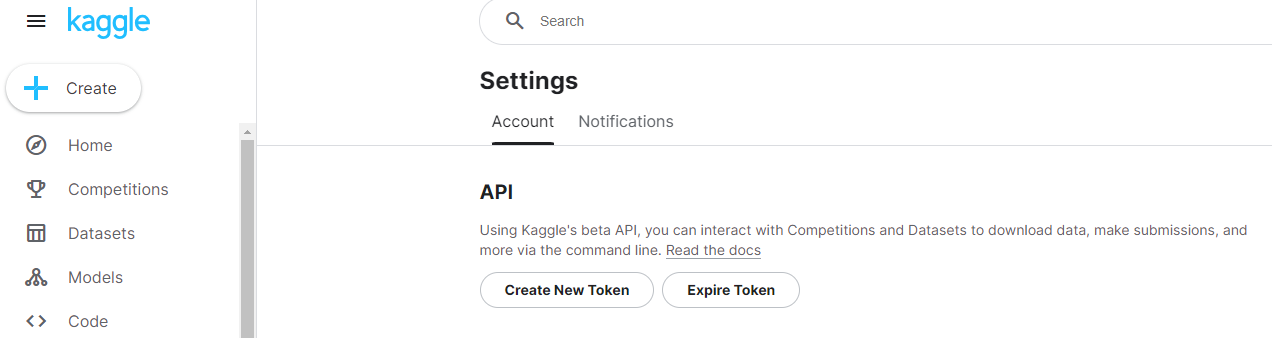

Ahora subimos el archivo a la carpeta de Drive que acabamos de crear.

Tras ello podremos ejecutar el siguiente código que genera una carpeta en Colab, obtiene el archivo subido en Drive y lo guarda en dicha carpeta, le cambia los permisos al archivo para ocultar el contenido de nuestras credenciales de Kaggle y descargamos el dataset de Chessman.

In [ ]:
!mkdir ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/db/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d niteshfre/chessman-image-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 68% 39.0M/57.6M [00:00<00:00, 209MB/s]
100% 57.6M/57.6M [00:00<00:00, 223MB/s]


Este dataset viene comprimido por lo que lo descomprimimos dentro de nuestra carpeta de Drive y borramos el zip del gestor de archivos de Colab.

In [ ]:
!unzip chessman-image-dataset.zip -d '/content/drive/My Drive/Colab Notebooks/db/'
!rm chessman-image-dataset.zip

Archive:  chessman-image-dataset.zip
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000000.JPG  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000001.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000002.JPG  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000003.png  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000004.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000006.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000007.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000008.jpg  
  inflating: /content/drive/My Drive/Colab Notebooks/db/Chessman-image-dataset/Chess/Bishop/00000009.png  


## División y procesamiento de datos

Primero, descargamos y descompriminos la carpeta que se encuentra en el link https://drive.google.com/drive/folders/13FKcZ2IQFWulkQyIzynS6yJKGS8TP51u?usp=drive_link y la metemos en nuestro entorno.

Debemos quitar las imagenes que no tengan un formato válido para realizar data augmentation.

In [2]:
def clean_data(dirname):
	directories = os.listdir(dirname)
	for dir in directories:
		img_directories = os.listdir(f"{dirname}/{dir}")
		for img_name in img_directories:
			ext = img_name.split('.')[-1]
			if (
				ext != "JPG" and ext != "jpg" and 
				ext != "png" and ext != "jpeg"
			):
				os.remove(f"{dirname}/{dir}/{img_name}")

In [3]:
clean_data("Chessman-image-dataset/Chess")

Ahora, dividimos el dataset entre datos de entrenamiento, de test y validación.

In [4]:
splitfolders.ratio('Chessman-image-dataset/Chess', output="Chessman-image-dataset/split", seed=1337, ratio=(.7, 0.15, 0.15))

Copying files: 551 files [00:02, 212.37 files/s]


Mapeamos las 6 piezas del dataset de número de clase a pieza y estandarizamos el tamaño de las imágenes a 64x64.

In [5]:
MAP_PIECES = {
    0: 'Bishop', 1: 'King', 2: 'Knight',
    3: 'Pawn', 4: 'Queen', 5: 'Rook'
}

IMG_SIZE = 64

Función de carga de datos de entrenamiento.

In [6]:
def load_train_set(dirname, map_pieces, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_pieces: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_pieces.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

Función de carga de datos de prueba.

In [7]:
def load_val_test_set(dirname, map_pieces, set_name, verbose=True):
	"""Esta función funciona de manera equivalente a la función load_train_set
	pero cargando los datos de test."""
	X_test = []
	y_test = []
	reverse_dict = {v: k for k, v in map_pieces.items()}
	for filename in glob.glob(dirname + '/*.*'):
		char_name = "_".join(filename.split('\\')[-1].split('_')[:-1])
		# print(char_name)
		if char_name in reverse_dict:
			image = cv2.imread(filename)
			image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
			X_test.append(image)
			y_test.append(reverse_dict[char_name])
	if verbose:
		print(f"Leídas {len(X_test)} imágenes de {set_name}")
	return np.array(X_test), np.array(y_test)

Debemos transformar los datos de test y validación para que la función los procese correctamente.
Los datos de test se encuentran segmentados en una carpeta por cada pieza por lo que recorremos los directorios y cada una de las imágenes, copiamos cada archivo fuera de la carpeta, añadiéndole el nombre de la pieza de la imagen y luego borramos cada una de estas carpetas.

In [8]:
def transform_val_test_data(dirname):
	test_directories = os.listdir(dirname)

	for dir in test_directories:
		files_to_copy = os.listdir(f"{dirname}/{dir}")
		for file_name in files_to_copy:
			shutil.copy(f"{dirname}/{dir}/{file_name}", f"{dirname}/{dir}_{file_name}")
		shutil.rmtree(f"{dirname}/{dir}")

https://www.youtube.com/watch?v=A1UXJhsMd70


https://www.geeksforgeeks.org/python-os-listdir-method/
https://www.linode.com/docs/guides/python-delete-file/

Hay que poner mas filtros y almacenar las imagenes generadas

In [9]:
def store_image(img, file_name, dir):
  img_pil = tf.keras.preprocessing.image.array_to_img(img) # Convertir imagen de TensorFlow a imagen PIL
  img_pil.save(os.path.join(dir, file_name))

In [10]:
def data_augmentation(dirname):
	train_directories = os.listdir(dirname)
	for dir in train_directories:
		img_dir_route = f"{dirname}/{dir}"
		img_directories = os.listdir(img_dir_route)
		for img_name in img_directories:
			img = PIL.Image.open(f"{img_dir_route}/{img_name}")
			img_width = img.size[0]
			img_height = img.size[1]
			for level in range(0, 5):
				# Cambio en la saturación de la imagen
				saturated_img = tf.image.adjust_saturation(img, level + 1)
				store_image(saturated_img, f"sat_{level}_{img_name}", img_dir_route)

				# Cambio en el brillo de la imagen
				bright_img = tf.image.adjust_brightness(img, (level + 1) / 10)
				store_image(bright_img, f"bri_{level}_{img_name}", img_dir_route)

				# Recorte aleatorio de la imagen
				crop_img = tf.image.random_crop(img, size = [int(img_height*0.7), int(img_width*0.7), 3])
				store_image(crop_img, f"cro_{level}_{img_name}", img_dir_route)
				
			for degrees in range(45, 360, 45):
				# Rotación de la imagen
				rotated_img = img.rotate(degrees, fillcolor = "darkgreen")
				store_image(rotated_img, f"deg_{degrees}_{img_name}", img_dir_route)

Almacenamos las rutas de los datos de entrenamiento, validación y prueba.

Llamamos a la función que tranformará los datos para cargar los datos de test/validacion

In [11]:
DATASET_TRAIN_PATH_COLAB = "Chessman-image-dataset/split/train"
DATASET_VAL_PATH_COLAB = "Chessman-image-dataset/split/val"
DATASET_TEST_PATH_COLAB = "Chessman-image-dataset/split/test"

In [12]:
transform_val_test_data(DATASET_VAL_PATH_COLAB)
transform_val_test_data(DATASET_TEST_PATH_COLAB)

In [13]:
data_augmentation(DATASET_TRAIN_PATH_COLAB)

Cargamos los datos de entrenamiento, test y validación.

In [28]:
X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_PIECES)
X_val, y_val = load_val_test_set(DATASET_TEST_PATH_COLAB, MAP_PIECES, "validación")
X_test, y_test = load_val_test_set(DATASET_TEST_PATH_COLAB, MAP_PIECES, "test")

Leyendo 1150 imágenes encontradas de Bishop
Leyendo 920 imágenes encontradas de King
Leyendo 1472 imágenes encontradas de Knight
Leyendo 1357 imágenes encontradas de Pawn
Leyendo 1104 imágenes encontradas de Queen
Leyendo 1357 imágenes encontradas de Rook
Leídas 89 imágenes de validación
Leídas 89 imágenes de test


In [29]:
y.shape

(7360,)

In [30]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

**Normalización de las imágenes.**

In [31]:
# Preprocessing normalización de las imágenes
# X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
# X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)
X = X / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

**Análisis de los datos a utilizar.**

In [32]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

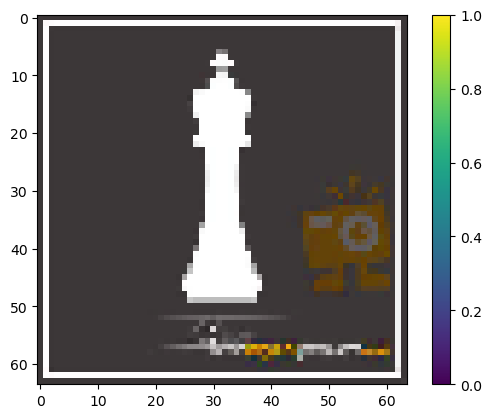

King
(64, 64, 3)


In [33]:
visualize_example(X[75]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_PIECES[y[75]]) # Acceso al diccionario
print(X[75].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [34]:
#batch_size=128
num_classes=6
epochs=5
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)

In [35]:
# convert class vectors to binary class matrices
y=keras.utils.to_categorical(y,num_classes)
y_val=keras.utils.to_categorical(y_val,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [36]:
X.shape

(7360, 64, 64, 3)

In [37]:
y.shape

(7360, 6)

**Parámetros por defecto de la capa de convolución:** <br>
*keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)*

In [42]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(64, 64, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(6, activation='softmax')
])

In [43]:
model.summary()
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,662 (2.62 MB)

 Trainable params: 686,662 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

*Observamos que el modelo tiene cerca de 3 millones de parámetros, se ha visto una mejora importante al añadir más neuronas en la capa dense_9, otros modelos probados con 200 neuronas solo alcanzaban un 65% de precisión. Hacemos dos máxpooling seguidos para reducir de 600000 a 4600 las neuronas en la capa flatten_5 y que no se dispare el número de parámetros pudiendo así aumentar el número de neuronas de la capa dense_9 que hemos observado mejora la precisión. Se usó categorical crossentropy porque las variables dependientes se transformaron en categorías y se usa la función de activation softmax en la capa de salida.*

**Comparación de modelos CNNs con un modelo de Fully Connected para este problema.**<br>
*El número de neuronas en la capa de entrada hace inviable entrenar un modelo Fully Connected que no usa capas convolucionales. Los filtros convolucionales permiten extraer características espaciales de las imágenes, frente a un modelo Fully Connected en el que no se aprovecha esta posibilidad.*


**Entrenamiento completo del mejor modelo.** <br>
*División de los datos en training/validation 80/20 para tener una buena estimación de los valores que nuestro modelo tendrá
en los datos de test, así como comprobar que no estamos cayendo en overfitting.*

In [44]:
history=model.fit(X, y, epochs=7, validation_split = 0.15)

Epoch 1/7
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.1843 - loss: 0.4712 - val_accuracy: 0.3161 - val_loss: 0.4230
Epoch 2/7
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3266 - loss: 0.4165 - val_accuracy: 0.5190 - val_loss: 0.3398
Epoch 3/7
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5105 - loss: 0.3427 - val_accuracy: 0.6114 - val_loss: 0.2891
Epoch 4/7
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6208 - loss: 0.2789 - val_accuracy: 0.6676 - val_loss: 0.2440
Epoch 5/7
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7199 - loss: 0.2174 - val_accuracy: 0.7092 - val_loss: 0.2191
Epoch 6/7
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7715 - loss: 0.1797 - val_accuracy: 0.7527 - val_loss: 0.1896
Epoch 7/7
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8149 - loss: 0.1475 - val_accuracy: 0.7627 - val_loss: 0.1791


**Análisis visual de los errores de la red.**

In [49]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

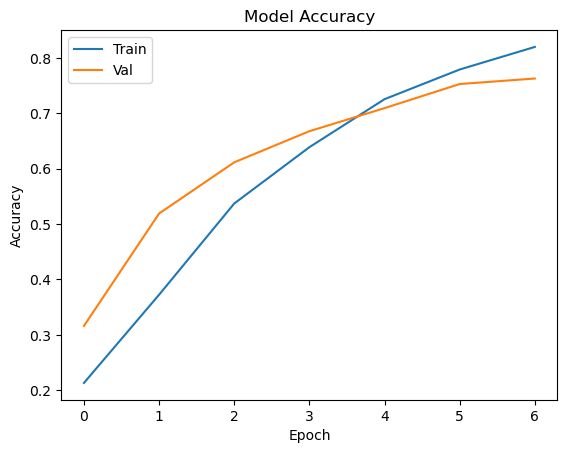

In [50]:
plot_acc(history)

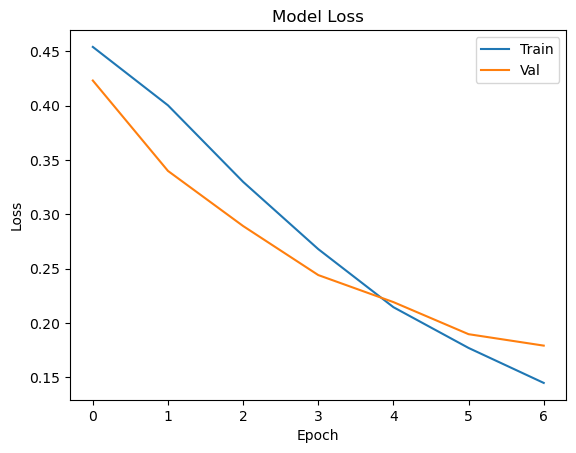

In [51]:
plot_loss(history)

*Viendo las gráficas observamos que con 5 épocas las líneas de loss y accuracy se vuelven prácticamente horizontales, por eso no seguimos entrenando.*

**Evaluación de los datos de test con este modelo.**

In [ ]:
model.evaluate(X_t, y_t, batch_size=32, verbose=1)

4/4 [==============================] - 0s 94ms/step - loss: 1.6970 - accuracy: 0.2609


[1.6969596147537231, 0.260869562625885]

*Observamos que sobre los datos de test el loss es 0.17 y la precisión de un 94%*

**Almacenamos todas las predicciones para los datos de test.**

In [ ]:
prediccion=model.predict(X_t, batch_size=32, verbose=1)  # Almacenamos todas las predicciones para los datos de test

4/4 [==============================] - 0s 4ms/step


In [ ]:
print(prediccion)
prediccion.shape

[[1.0436461e-05 4.0393564e-09 8.6248328e-05 ... 4.1252917e-09
  3.8302916e-09 1.1701950e-06]
 [4.2870491e-07 7.4545491e-12 1.6985687e-05 ... 2.1730613e-13
  1.3417210e-10 2.1972285e-11]
 [1.3970128e-05 1.3535890e-04 1.8186621e-04 ... 1.3414168e-04
  3.1769969e-02 2.9720401e-05]
 ...
 [5.3526263e-19 1.4045362e-21 2.8902658e-14 ... 2.2493529e-22
  4.5590745e-24 1.3800931e-23]
 [8.3708455e-04 3.1794378e-04 5.7568890e-03 ... 9.0936762e-01
  3.1456554e-03 4.5966716e-03]
 [1.4757951e-07 1.6051710e-10 1.5710880e-07 ... 1.0878345e-05
  1.0580720e-05 2.7247069e-07]]


(890, 18)

In [ ]:
print(prediccion[0]) # Ejemplo de predicción para el primer elemento del test.
predicho = np.argmax(prediccion[0])  # Nos quedamos con la posición del valor máximo de las estimaciones de probabilidad para cada una de las 18 clases.
print(predicho)
print(MAP_CHARACTERS[predicho]) # Acceso al diccionario para mostrar el nombre del personaje predicho.

[1.0436461e-05 4.0393564e-09 8.6248328e-05 9.9808145e-01 4.5345655e-06
 6.2164123e-05 5.6259819e-09 1.7311788e-03 4.5602128e-10 4.9568888e-07
 2.0808417e-05 8.2596607e-08 4.4503784e-07 8.5214401e-07 4.0693501e-10
 4.1252917e-09 3.8302916e-09 1.1701950e-06]
3
charles_montgomery_burns


In [ ]:
y_t.shape

(890, 18)

**Análisis de resultados, obtención de métricas de precision y recall por clase y análisis de qué clases obtienen mejores o peores resultados.**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
informe = classification_report(np.argmax(y_t,axis=1), np.argmax(prediccion,axis=1))
print(informe)


              precision    recall  f1-score   support

           0       0.97      0.79      0.87        48
           1       0.96      1.00      0.98        50
           2       0.94      0.94      0.94        50
           3       0.90      0.90      0.90        48
           4       1.00      0.94      0.97        50
           5       0.96      0.92      0.94        49
           6       0.91      0.98      0.94        50
           7       0.85      1.00      0.92        50
           8       0.92      0.98      0.95        50
           9       0.98      1.00      0.99        50
          10       0.92      0.92      0.92        50
          11       0.98      0.98      0.98        50
          12       0.92      0.94      0.93        49
          13       0.94      0.90      0.92        50
          14       0.94      0.98      0.96        49
          15       0.98      0.90      0.94        50
          16       1.00      0.94      0.97        50
          17       0.96    

*Vemos que la menor precisión es del 85% al clasificar las imágenes de Homer Simpson (número 7), mientras que la mayor precisión se consigue al clasificar las imágenes correspondientes a Chief Wiggum (número 4) y Principal Skinner (número 16).*


**Mejoras** <br>
*Podríamos hacer data augmentation mediante el preprocesamiento de las imágenes predichas con menor precisión usando la clase ImageDataGenerator. Para ello podríamos fijarnos si están descentradas, oscuras etc. realizando transformaciones de rotación, desplazamientos y cambios de brillo según el caso.*


